The goal of this project is to analyze what boardgame characteristics are associated to **best-selling games**.

In [274]:
# Data handling
import pandas as pd
import numpy as np
import random
import missingno as msn
from sklearn.impute import SimpleImputer
from scipy import stats
import datetime as dt
# Scrapping data
from bs4 import BeautifulSoup
import requests
import csv
import re
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm 
from pandas.plotting import scatter_matrix
import seaborn as sns
from matplotlib import dates as mpl_dates
# Data Split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
# Data Pre-Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Assesing model performance
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score

# Tunning
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Data Cleaning and feature engineering

[Data collection](https://www.kaggle.com/gabrio/board-games-dataset)

In [275]:
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 1000)

In [289]:
df = pd.read_csv("data/BoardGames.csv")

FileNotFoundError: [Errno 2] File data/BoardGames.csv does not exist: 'data/BoardGames.csv'

In [ ]:
df.drop("row_names", axis=1, inplace=True)

In [ ]:
df.columns = df.columns.str.replace("details.", "")
df.columns = df.columns.str.replace("attributes.", "")
df.columns = df.columns.str.replace("boardgame", "")
df.columns = df.columns.str.replace("polls.", "")
df.columns = df.columns.str.replace("stats.", "")

In [ ]:
# I realized a column with a single value. Here I define a function that removes those columns with a unique value just in case there are more columns
def unique_val_dropper(col_name):
    for col_name in df.columns:
        if len(df[col_name].unique()) == 1:
            df.drop(col_name, axis=1, inplace=True)
        else:
            pass

In [ ]:
# it may be interesting to have the description length as an independent feature
df["description_length"] = df["description"].str.len()

In [ ]:
df.apply(unique_val_dropper)

Next, lets look at the nan values

In [ ]:
df.isna().sum()

We need to deal with these **nan values**. Next i will divide the df to look at categorical and numerical attributes separately since the approaches to deal with nan values may differ between the two:
* For the numerical features we need to see the distribution of the data and decide the inputing criteria for those nan values.
* For the categorical values we need to figure out if perhaps some feature engineering can be achieved and nans grouped into a catagorical value of their own.

In [ ]:
# divinding out data set into numeric and object. 
df_num = df.select_dtypes(include=["int64", "float64"])
df_cat = df.select_dtypes(include="object")

Lets get rid of those numerical atributes with mode than 40% nan values

In [ ]:
# defining a function to remove those rows with mode than 40% of nan values

def nan_dropper(col_name):
    for col_name in df_num.columns:
        if ((df_num[col_name].isna().sum())/len(df_num[col_name])) > 0.40:
            df_num.drop(col_name, axis=1, inplace=True)
        else:
            pass

In [ ]:
df_num.apply(nan_dropper)

In [ ]:
df_num.isna().sum()

In [ ]:
df.dtypes

Lets now inspect the distribution of the numerical values across all atributes using boxplots and to get a sense of the amount of possible outliers in each category.

In [ ]:
plt.style.use("classic")

df_num.plot(kind='box', subplots=True, layout=(3,7), sharex=False, sharey=False, figsize=(16,8), color="b")
plt.tight_layout()
# plt.savefig("boxplots", dpi=400)
plt.show()

We can observe that there are some clear outliers such the negative yearpublish. Before removing outliers we need to decide what numerical attributes we want to keep.

We also observe that those attributes with few nan value have a large amount of outliers. Hence median imputer is preferred in this case to fill in the missing nan values.

In [ ]:
imputer = SimpleImputer(strategy="median")
columns_df_num = df_num.columns
X_num_imputed = imputer.fit_transform(df_num)
df_num = pd.DataFrame(X_num_imputed, columns=columns_df_num)

Let's remove outliers beased on the **Z-score**

In [ ]:
df_num = df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

Let's focus on the categorical values next

The code below allows to combine the information about recommended number of players into a single column with numbers from 1 to 10.

In [ ]:
df_cat.iloc[:,16:-1].columns

In [ ]:
suggested_players = []
for col_name in df_cat.iloc[:,16:-1].columns:
    for i in range(len(df_cat[col_name])):
        if df_cat[col_name][i] in ['NotRecommended', 'Recommended', 'Best']: 
            suggested_players.append((i, df_cat[col_name][i], col_name)) 
 

In [ ]:
df_recommendation = pd.DataFrame.from_records(suggested_players, columns =['Index', 'Recommendation', 'Num_players'])

In [ ]:
df_recommendation["Num_players"] = df_recommendation["Num_players"].str.replace("suggested_numplayers.", "")

In [ ]:
df_recommendation.sort_values(by=["Index", "Recommendation"], inplace=True)

In [ ]:
df_recommendation = df_recommendation.reset_index(drop=True)

In [ ]:
df_recommendation["Length"] = df_recommendation["Recommendation"].apply(lambda x: len(x)) # using Length as a helper column

In [ ]:
grouped = df_recommendation.groupby(["Index"])

In [ ]:
bool_rec = grouped.apply(lambda x: x["Length"] == x["Length"].min())

In [ ]:
df_bool = pd.DataFrame(bool_rec)

In [ ]:
df_bool = df_bool.droplevel(1)

In [277]:
np.array(df_bool["Length"]) # we will use the bool array to select the columns from the df_recommendation df

array([ True, False, False, ..., False, False, False])

In [278]:
df_recon = df_recommendation.loc[(np.array(df_bool["Length"]))]

In [279]:
df_recon.drop_duplicates(subset="Index", inplace=True)

In [280]:
df_recon = df_recon.set_index("Index")

In [281]:
df_recon.drop("Length", axis=1, inplace=True)

In [282]:
df_recon["Recommendation"].value_counts()

Best              21186
Recommended        1697
NotRecommended      439
Name: Recommendation, dtype: int64

In [283]:
df_recon = df_recon.loc[df_recon["Recommendation"].isin(["Best", "Recommended"])] # we only want the recommended ones

In [284]:
df_recon.drop("Recommendation", axis=1,inplace=True)

In [285]:
df_recon.columns = ["Num_players_Recommended"]

In [286]:
df_cat = df_cat.join(df_recon, how='outer')

ValueError: columns overlap but no suffix specified: Index(['Num_players_Recommended'], dtype='object')

In [ ]:
df_cat.drop(df_cat.iloc[:,16:-3].columns, axis=1, inplace=True)

Next lets keep only the categorical useful categorical columns for our analyses

In [ ]:
df_cat.drop(["game.type", "image", "thumbnail","compilation","implementation", "integration", "t.links.concat.2....", "suggested_numplayers.Over", "category"], axis=1, inplace=True)

In [ ]:
df_cat.isna().sum()

In [ ]:
df_cat["family"][2]

Lets create some categorical groups using the nan values:

In [ ]:
df_cat["description"] = df_cat["description"].fillna("No description")
df_cat["artist"] = df_cat["artist"].fillna("No artist")
df_cat["designer"] = df_cat["designer"].fillna("No designer")
df_cat["publisher"] = df_cat["publisher"].fillna("No publisher")
df_cat["Num_players_Recommended"] = df_cat["Num_players_Recommended"].fillna(0)

I will convert the columns expansion and language dependence on boolan(0,1) type

In [ ]:
df_cat["expansion"] = df_cat["expansion"].apply(lambda x: 0 if x in [np.nan] else 1)
df_cat["language_dependence"] = df_cat["language_dependence"].apply(lambda x: 0 if x in [np.nan] else 1)

In [ ]:
def game_classifier(item):
    
    if item in [np.nan]:
        return "Unclassified"
    
    elif any(x in item.lower() for x in ["pattern building","pattern recognition"]):
        return "Puzzle"
    
    elif any(x in item.lower() for x in ["card","deck","hand management","trick-talking","set collection"]):
        return "Cards"
    
    elif ("roll" in item.lower()) | ("rolling" in item.lower()):
        return "Dices"
    
    elif any(x in item.lower() for x in ["area control","strategy","tile placement", "simulation","allowance system",
                                         "point to point movement","area movement","grid movement","hex-and-counter"]):
        return "Board Strategy"

    elif ("memory" in item.lower()):
        return "Memory"
    
    elif ("bidding" in item.lower()) | ("betting" in item.lower()):
        return "Betting"
    
    elif ("luck" in item.lower()) | ("rock-paper-scissors" in item.lower()):
        return "Luck"
    
    elif ("co-operative" in item.lower()) | ("partnerships" in item.lower()):
        return "co-operative"
    
    elif ("story telling" in item.lower()) | ("storytelling" in item.lower()):
        return "Story telling"
    
    elif any(x in item.lower() for x in ["drawing", "paper-and-pencil", "acting","role playing", "singing"]):
        return "Drawing/Acting"
    
    elif ("simultaneous action" in item.lower()):
        return "Reaction Game"
    
    else:
        return "Other"

In [ ]:
df_cat["Type of game"] = df_cat["mechanic"].apply(game_classifier)

In [ ]:
df_cat["Type of game"].value_counts()

We can join now the df_num and df_cat

In [ ]:
df = pd.concat([df_num, df_cat], axis=1, sort=False)

In [ ]:
df.drop(["family", "mechanic","stddev", "total"], axis=1, inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
df.reset_index(drop=True, inplace=True)

Finally we need represent the Owner variable sold by unit of time, to compare old and new games. Since we have the year_published data, we can easily calculate the **number of games owned by year** by dividing the owner number by the year the game has been in the market (2020 - published year)

In [ ]:
df["owned by year"] = df["owned"]/(2020 - df["yearpublished"])

In [ ]:
df["yearpublished"] = df["yearpublished"].astype(int)

In [ ]:
df

## 2. Exploratory Data Analyses

First, lets explore how the target variable (number of users owning the game) is relate to some of the ***categorical variables** in our dataset.

In [ ]:
# We can see most games are rated with 0 difficulty
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(x='owned by year', bins=30, data=df)
plt.title("Target distribution", fontsize=20)
plt.xlabel("Owners by year", fontsize=16)
plt.ylabel("count", fontsize=16)
# plt.savefig("target_values_distribution.png", dpi=400)
plt.show()

We observe that there are many games with 0 owners and 0 users rating. Here I will be using for the modeling those games with at least **20 users** owning and rating the game, since need user rating to know what motivates users to buy a game.

In [ ]:
df = df[((df["owned by year"] > 10) & (df["usersrated"] > 10 ))]

In [ ]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(x="owned by year", bins=30, data=df)
plt.title("Target distribution", fontsize=20)
plt.xlabel("Owners", fontsize=16)
plt.ylabel("count", fontsize=16)
# plt.savefig("target_values_distribution.png", dpi=400)
plt.show()

In [ ]:
df.shape

**2.1 What games people buy the most**

In [ ]:
df_types_user = pd.pivot_table(df, index=["Type of game"], values=["owned by year"], aggfunc=["median", "std"]).reset_index()

In [ ]:
df_types_user.columns = ["Type of game", "Number of owners", "std"]

In [ ]:
df_types_user.sort_values(by="Number of owners", inplace=True, ascending=False)

In [ ]:
ordered_list = list(df_types_user["Type of game"])

ValueError: Could not interpret input 'Type of game'

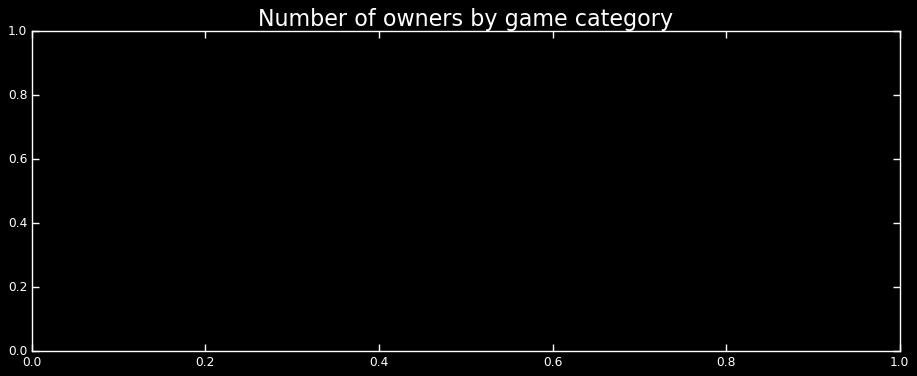

In [273]:
plt.subplots(figsize=(14,5))
plt.title("Number of owners by game category", fontsize=20)
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Type of game", y="owned by year", data=df, order = ordered_list, palette = sns.color_palette("Accent"), estimator=np.median) # hue=
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="40", fontsize=18)
plt.ylabel("Game Owners (Median)")
plt.savefig("type_of_game_owners.png", dpi=300, bbox_inches="tight")
plt.show()

Seems that **memory games** are the least sold whilst **card games** are sold more frequently

**2.2 What about game difficulty? Do people buy difficult games?** For this we can use the weight, which is board game terms refers to the difficulty of learning and playing the game.

In [203]:
df["weight_level"] = df["averageweight"].apply(int)

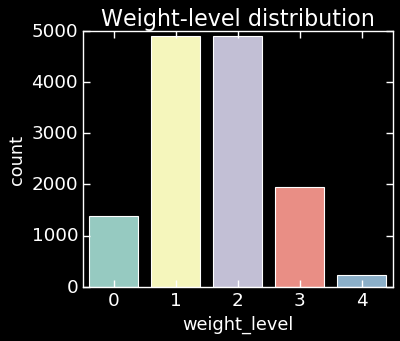

In [204]:
# We can see most games are rated with 0 difficulty

plt.rcParams["figure.figsize"] = (5,4)
ax = sns.countplot(x='weight_level', data=df)
ax.set_title("Weight-level distribution", fontsize=20)
ax.set_xlabel("weight_level", fontsize=16)
ax.set_ylabel("count", fontsize=16)
# plt.savefig("target_values_distribution.png", dpi=400)
plt.show()

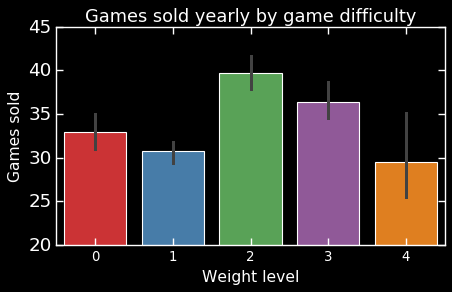

In [205]:
plt.subplots(figsize=(6,4))
plt.title("Games sold yearly by game difficulty", fontsize=16)
# sns.set_context("notebook", font_scale=1)
sns.barplot(x="weight_level", y="owned by year", data=df, palette = sns.color_palette("Set1"), estimator=np.median) # hue=
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(fontsize=12)
plt.ylim(20,45)
plt.ylabel("Games sold", fontsize=14)
plt.xlabel("Weight level", fontsize=14)
#plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.tight_layout()
#plt.savefig("game_level.png", dpi=300)
plt.show()

It appears that users buy mostly the games with **medium difficulty level**

2.3 Lets also see what are the **publisher, designer, artist and board games** with higher sales

In [206]:
artists_p = pd.pivot_table(df, index=["artist"], values=["owned by year"], aggfunc=["median", "std", "count"]).reset_index()

In [207]:
artists_p.columns = ["artists", "owners(yearly)", "std", "count"]

In [208]:
artists_p = artists_p.sort_values(by="owners(yearly)", ascending=False)

In [209]:
# I will focus on those artist that created more than 10 games
artists_p = artists_p.loc[artists_p["count"]>10]

In [210]:
top10_artists = artists_p.sort_values(by="owners(yearly)", ascending=False).head(10)

In [211]:
top10_artists

,artists,owners(yearly),std,count
3084,Mihajlo Dimitrievski,190.625000,163.012731,20
2288,Juliet Breese,180.250000,112.359213,11
2547,"Lars-Arne ""Maura"" Kalusky",163.000000,113.157714,19
950,Cyrille Daujean,152.461538,66.259040,21
3278,Oliver Schlemmer,142.000000,129.653018,25
2124,John Ariosa,123.600000,76.693576,25
1580,Gary Simpson,106.235714,112.549786,12
226,"Andrea Cofrancesco,Mathieu Harlaut",102.833333,96.207800,16
4474,William Bricker,100.904762,59.877859,24
2501,Kwanchai Moriya,100.100000,57.833331,14


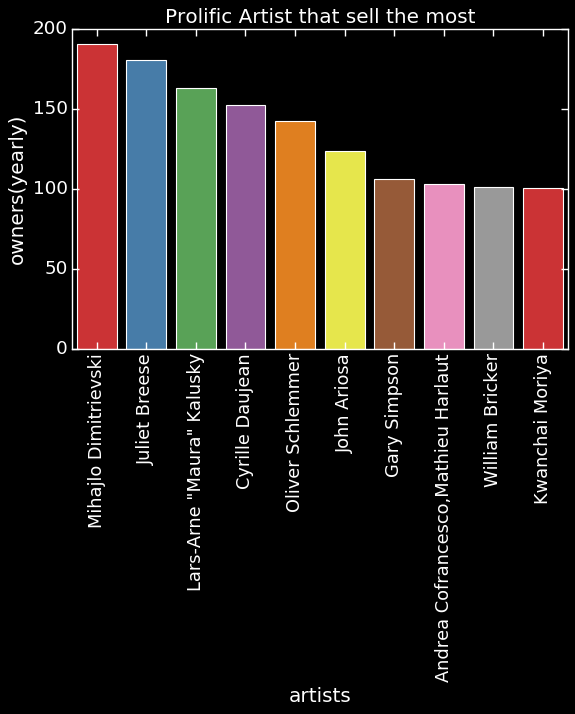

In [212]:
plt.subplots(figsize=(8,5))
plt.title("Prolific Artist that sell the most")
sns.barplot(x="artists", y="owners(yearly)", data=top10_artists, palette = sns.color_palette("Set1")) # yerr=df[std]
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="90", fontsize=16)
plt.ylabel("owners(yearly)")
#plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.show()

In [213]:
designer_p = pd.pivot_table(df, index=["designer"], values=["owned by year"], aggfunc=["median", "std", "count"]).reset_index()

In [214]:
designer_p.columns = ["designer", "owners(yearly)", "std", "count"]

In [215]:
designer_p = designer_p.sort_values(by="owners(yearly)", ascending=False)

In [216]:
# I will focus on those publishers that created more than 10 games
designer_p = designer_p.loc[designer_p["count"]>10]

In [217]:
top10_designers = designer_p.sort_values(by="owners(yearly)", ascending=False).head(10)

In [218]:
top10_designers

,designer,owners(yearly),std,count
3695,"Richard Garfield,Lukas Litzsinger",303.800000,111.874378,21
3627,"Raphaël Guiton,Jean-Baptiste Lullien,Nicolas R...",236.400000,232.147073,13
658,"Caleb Grace,Matthew Newman",203.166667,72.282141,17
1284,Donald X. Vaccarino,164.250000,137.131070,25
775,Chris Handy,152.000000,22.783334,19
20,"Aaron Dill,John Kovaleski,Sean Sweigart",147.157143,197.740058,22
886,Colby Dauch,145.000000,85.446232,31
2948,Matt Leacock,137.250000,97.689621,11
4021,Seiji Kanai,133.537500,163.186227,14
2611,Kristian Amundsen Østby,133.523810,118.763581,16


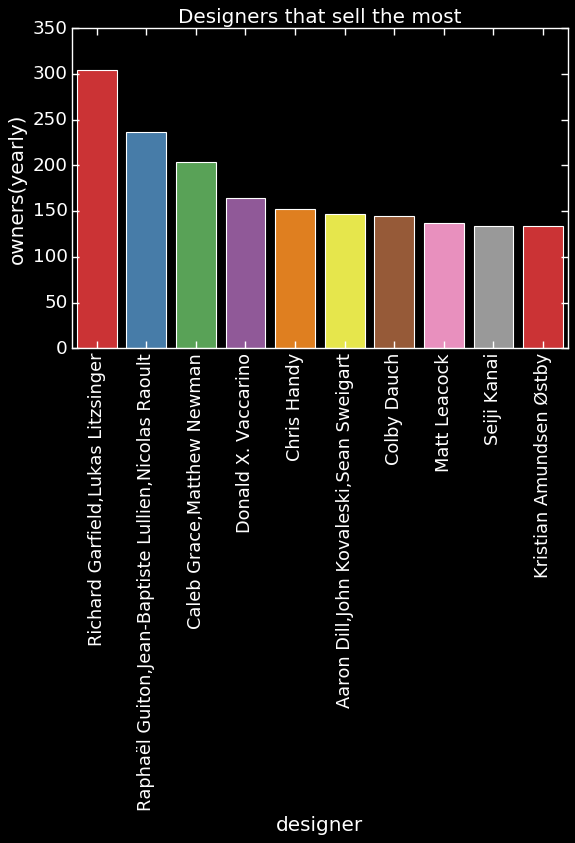

In [219]:
plt.subplots(figsize=(8,5))
plt.title("Designers that sell the most")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="designer", y="owners(yearly)", data=top10_designers, palette = sns.color_palette("Set1")) # hue=
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="90", fontsize=16)
plt.ylabel("owners(yearly)")
#plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.show()

If we take a look to the publisher data in detail we see that the data is not actually well grouped by plublisher. To group it properly, I will generate a list of all boarddgame publishers available at [Wikipedia](https://en.wikipedia.org/wiki/List_of_game_manufacturers). 
* I will scrape this data for this link and add it to a list
* Generate a df with the index and publishers that could be grouped
* Outer Join the main df and the publisher_grouped df
* Lastly, fill in the nan values of the new column with the original publisher column
* Drop the old publisher column

In [220]:
publisher_list = []

website = "https://en.wikipedia.org/wiki/List_of_game_manufacturers"
source = requests.get(website).content
html_soup = BeautifulSoup(source, 'lxml')
pretty = html_soup.prettify() # to peek at the html code

In [221]:
full_list = html_soup.find("div", class_="mw-parser-output").find_all(["ul","li","a","title"])

In [222]:
list_publishers=[]
for i in range(len(full_list)):
    try:
        pub = (re.search(r"\"(\w+\s?){,5}\"", str(full_list[i])).group(0))
        if len(pub) > 0:
            list_publishers.append(pub)
    except AttributeError:
        pass

In [223]:
list_publishers = list_publishers[8:415]

In [224]:
list_publishers = list(pd.Series(list_publishers).str.replace("\"","").drop_duplicates())

In [225]:
df = df.reset_index(drop=True)

In [226]:
publisher_group = []
for item in list_publishers:
    for i in range(len(df["publisher"])):
        if item.lower() in df["publisher"][i].lower():
            publisher_group.append((i, item)) 

In [227]:
Publisher_grouped = pd.DataFrame(publisher_group, columns =['Index', 'Publisher']) 

In [228]:
Publisher_grouped_i = Publisher_grouped.set_index("Index")

In [229]:
df = df.join(Publisher_grouped_i, how='outer')

In [230]:
df["Publisher"][df["Publisher"].isnull()] = df["publisher"]

In [231]:
df.drop("publisher", axis=1, inplace=True)

In [232]:
publisher_p = pd.pivot_table(df, index=["Publisher"], values=["owned by year"], aggfunc=["median", "std", "count"]).reset_index()

In [233]:
publisher_p.columns = ["Publisher", "owners(yearly)", "std", "count"]

In [234]:
publisher_p = publisher_p.sort_values(by="owners(yearly)", ascending=False)

In [235]:
# I will focus on those publishers that created more than 10 games
publisher_p = publisher_p.loc[publisher_p["count"]>10]

In [236]:
top10_publishers = publisher_p.sort_values(by="owners(yearly)", ascending=False).head(10)

In [237]:
top10_publishers

,Publisher,owners(yearly),std,count
1361,Daily Magic Games,190.000000,186.192132,13
1177,"Clever Mojo Games,Game Salute",187.833333,119.765379,21
3249,Upper Deck Entertainment,180.600000,181.883356,17
2802,Perplext,151.250000,22.318387,18
3152,Tasty Minstrel Games,140.833333,148.578559,26
1310,"Cube Factory of Ideas,Plaid Hat Games",131.714286,79.802884,17
3309,White Wizard Games,122.000000,119.407564,37
1380,Days of Wonder,120.750000,147.299824,51
1880,Gamelyn Games,120.166667,100.558999,12
865,"Battlefront Miniatures Ltd,Gale Force Nine, LLC",111.200000,140.381236,11


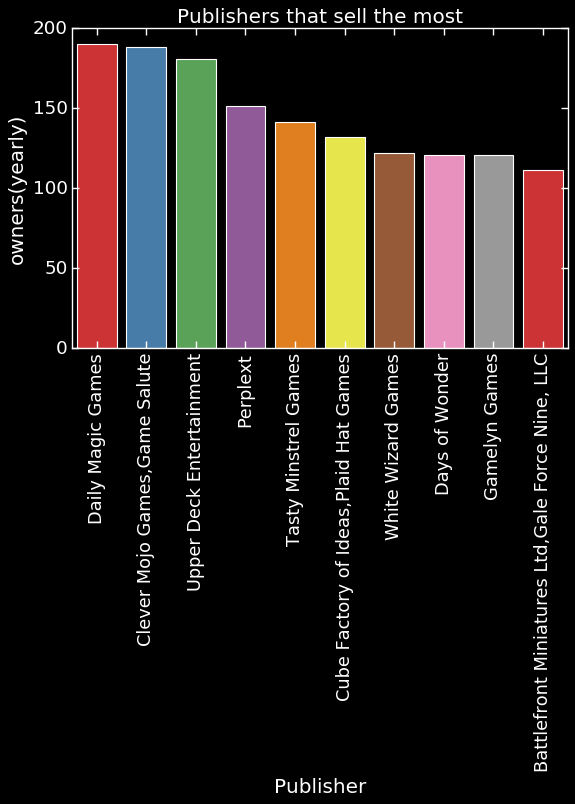

In [238]:
plt.subplots(figsize=(8,5))
plt.title("Publishers that sell the most")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Publisher", y="owners(yearly)", data=top10_publishers, palette = sns.color_palette("Set1")) # hue=
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="90", fontsize=16)
plt.ylabel("owners(yearly)")
#plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.show() 

It seems that **Daily Magic Games sell the most** with a total of 200 games yearly. What kind of games do this company sells?

In [239]:
Magic_Games = df.loc[(df["Publisher"]=="Daily Magic Games")]["Type of game"].value_counts()

In [240]:
Magic_Games

Cards     12
Puzzle     1
Name: Type of game, dtype: int64

In [241]:
Deck = df.loc[(df["Publisher"]=="Upper Deck Entertainment")]["Type of game"].value_counts()

In [242]:
Deck

Cards    14
Dices     3
Name: Type of game, dtype: int64

In [243]:
Clever = df.loc[(df["Publisher"]=="Clever Mojo Games,Game Salute")]["Type of game"].value_counts()

In [244]:
Clever

Dices           12
Cards            6
Unclassified     3
Name: Type of game, dtype: int64

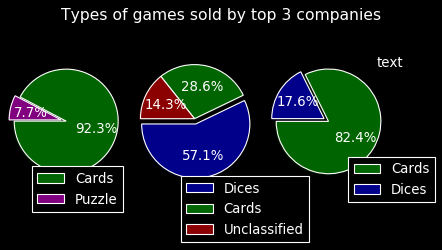

In [272]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(6,3))
ax1_labels = Magic_Games.index
ax1_sizes = Magic_Games
ax1_explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax1.pie(ax1_sizes, explode=ax1_explode, autopct='%1.1f%%',
        shadow=True, startangle=180, colors = ["darkgreen", "purple"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(ax1_labels, fontsize=12, bbox_to_anchor=(1.1,0.3))

ax2_labels = Clever.index
ax2_sizes = Clever
ax2_explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax2.pie(ax2_sizes, explode=ax2_explode, autopct='%1.1f%%',
        shadow=True, startangle=180, colors = ["darkblue", "darkgreen", "darkred"])
ax2.axis('equal')  # Equal aspect 
ax2.legend(ax2_labels, fontsize=12, bbox_to_anchor=(1.6,0.25))

ax3_labels = Deck.index
ax3_sizes = Deck
ax3_explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax3.pie(ax3_sizes, explode=ax3_explode, autopct='%1.1f%%',
        shadow=True, startangle=180, colors = ["darkgreen", "darkblue"])
ax3.axis('equal')  # Equal aspect 
ax3.legend(ax3_labels, fontsize=12, bbox_to_anchor=(1.55,0.35))

plt.text(s="text", x=1, y=1)
plt.title("Types of games sold by top 3 companies", fontsize=14, loc="right")
plt.tight_layout()
#plt.savefig("pie_chart_games.png", dpi=300, bbox_inches="tight")
plt.show()

We can see that Daily Magic Games principally sells card games

In [246]:
top_games = df.sort_values(by="owned by year", ascending=False).head(10)

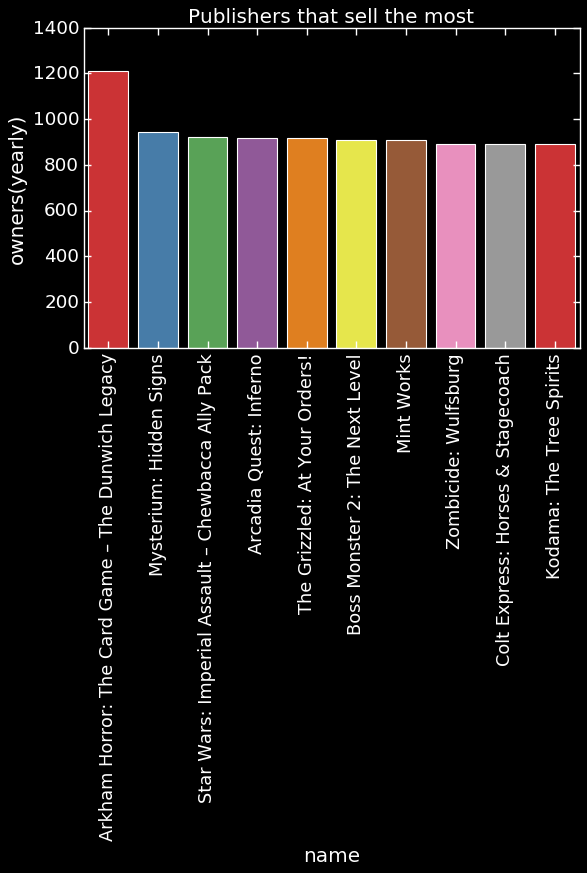

In [247]:
plt.subplots(figsize=(8,5))
plt.title("Publishers that sell the most")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="name", y="owned by year", data=top_games, palette = sns.color_palette("Set1")) # hue=
# plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="90", fontsize=16)
plt.ylabel("owners(yearly)")
plt.show()

**2.4** Finally, in **what year** the most sold games were published?

In [248]:
year_p = pd.pivot_table(df, index=["yearpublished"], values=["owned"], aggfunc=["sum", "std", "count"]).reset_index()

In [249]:
year_p.head()

,yearpublished,sum,std,count
,,owned,owned,owned
0,1894,4011.0,0.0,3
1,1925,1608.0,NaN,1
2,1937,1333.0,NaN,1
3,1938,1023.0,NaN,1
4,1939,912.0,NaN,1


In [250]:
year_p.columns = ["year", "total_games_sold", "std", "total_games_published"]

In [251]:
year_p["sold_by_game"] = year_p["total_games_sold"]/ year_p["total_games_published"]

In [252]:
year_p = year_p.sort_values(by="year")

In [253]:
year_p["year"] = pd.to_datetime(year_p["year"], format="%Y").dt.year # int to dt object with format %Y

In [254]:
years_range = year_p.loc[(year_p["year"] <= 2018)&(year_p["year"] > 1960)]

In [255]:
years_range["year"]  = years_range["year"].apply(str)

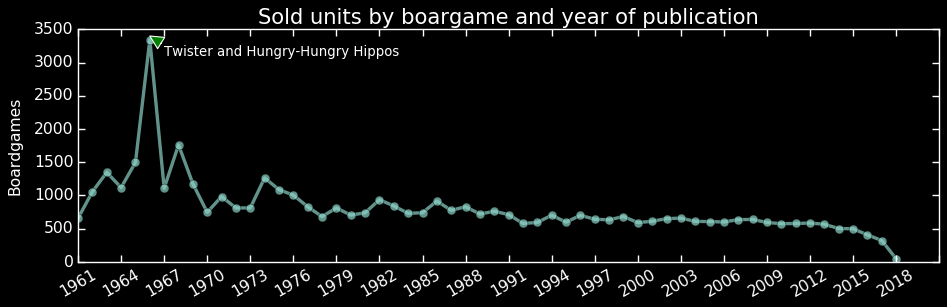

In [268]:
plt.subplots(figsize=(12,4))

# plt.plot(years["year"], years["total_games_published"], markersize=2.5, linewidth=2, linestyle='-')
# plt.plot(years["year"], years["total_games_sold"], markersize=2.5, linewidth=1, linestyle='-')
plt.plot_date(years_range["year"], years_range["sold_by_game"], markersize=8, linewidth=3, linestyle='-', alpha=0.7)
plt.title("Sold units by boargame and year of publication", fontsize=19)
plt.ylabel("Boardgames", labelpad=10, fontsize=14)
ymax=max(years_range["sold_by_game"])
xmax="1966"
plt.annotate(s = "Twister and Hungry-Hungry Hippos",xy=(5,3400),xytext=(6, 3100),
           arrowprops=dict(facecolor='green', width=0.02), xycoords="data")
plt.xticks(np.arange(0, 62, 3),rotation="30", fontsize=14)
plt.yticks(rotation="horizontal", fontsize=14)
#plt.savefig("yearpub_gamessold.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

In the year 1966 some board games were published which have been sold extensively. What boardgames are those?

In [257]:
print(df[(df["yearpublished"] == 1966)].name.unique())

['Twister' 'Hungry Hungry Hippos']


These highly sold games were **[Twister]("https://en.wikipedia.org/wiki/Twister_(game)")** and **[Hungry Hungry Hippos]("https://en.wikipedia.org/wiki/Hungry_Hungry_Hippos")**

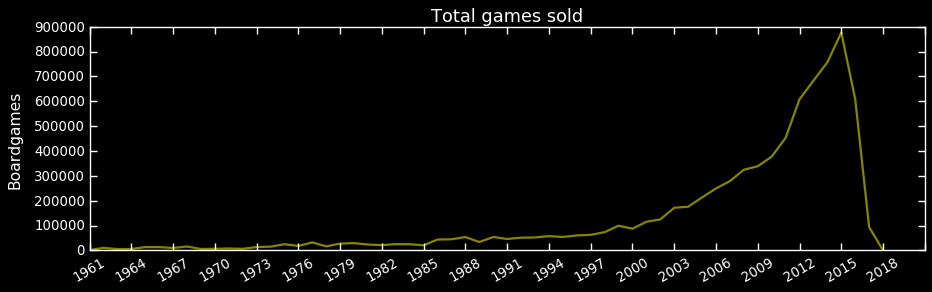

In [258]:
plt.subplots(figsize=(12,4))

# plt.plot(years["year"], years["total_games_published"], markersize=2.5, linewidth=2, linestyle='-')
plt.plot(years_range["year"], years_range["total_games_sold"],  color="y", linewidth=2, linestyle='-', alpha=0.7)
#plt.plot_date(years_range["year"], years_range["sold_by_game"], markersize=5, linewidth=2, linestyle='-', alpha=0.7)
plt.title("Total games sold", fontsize=16)
plt.ylabel("Boardgames", labelpad=10, fontsize=14)
plt.xticks(np.arange(0, 62, 3),rotation="30", fontsize=12)
plt.yticks(rotation="horizontal", fontsize=12)
plt.tight_layout()

In 2014 is the year when most sold games were published. How many were published and what games were the most sold?

In [259]:
len(df[(df["yearpublished"] == 2015)].name.unique())

1756

**1756** games were published compared to two games published in 1966!

In [260]:
top_sold_2015 = df[(df["yearpublished"] == 2015)].sort_values(by="owned", ascending=False).head(10)

In [261]:
top_sold_2015[["name", "owned"]] # Intersting, I do not personally know any of those games.

,name,owned
10051,Star Wars: Imperial Assault – Chewbacca Ally Pack,4607.0
10633,Boss Monster 2: The Next Level,4552.0
11231,Colt Express: Horses & Stagecoach,4451.0
10645,Blood Rage: Mystics of Midgard,4421.0
10622,Blood Rage: Gods of Ásgard,4286.0
10050,Star Wars: Imperial Assault – IG-88 Villain Pack,3967.0
10049,Star Wars: Imperial Assault – Royal Guard Cham...,3870.0
10399,Camel Up: Supercup,3775.0
10764,Evolution: Flight,3686.0
10052,Star Wars: Imperial Assault – Rebel Troopers A...,3602.0


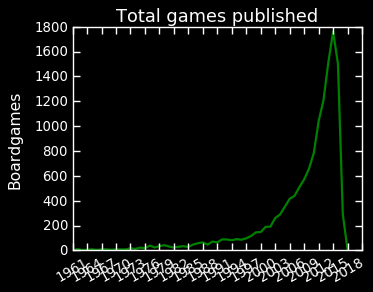

In [262]:
plt.plot(years_range["year"], years_range["total_games_published"], markersize=2.5, linewidth=2, linestyle='-', color="g")
# plt.plot(years_range["year"], years_range["total_games_sold"],  color="y", linewidth=2, linestyle='-', alpha=0.7)
#plt.plot_date(years_range["year"], years_range["sold_by_game"], markersize=5, linewidth=2, linestyle='-', alpha=0.7)
plt.title("Total games published", fontsize=16)
plt.ylabel("Boardgames", labelpad=10, fontsize=14)

plt.xticks(np.arange(0, 62, 3),rotation="30", fontsize=12)
plt.yticks(rotation="horizontal", fontsize=12)
plt.tight_layout()

**One-hot encoding:**

We will one hot encode the attribute "Type of game" since is an characteristic that cannot be ordered

In [263]:
df = pd.get_dummies(df, columns=["Type of game"])

In [264]:
df.columns = df.columns.str.replace("Type of game_", "")

In [265]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

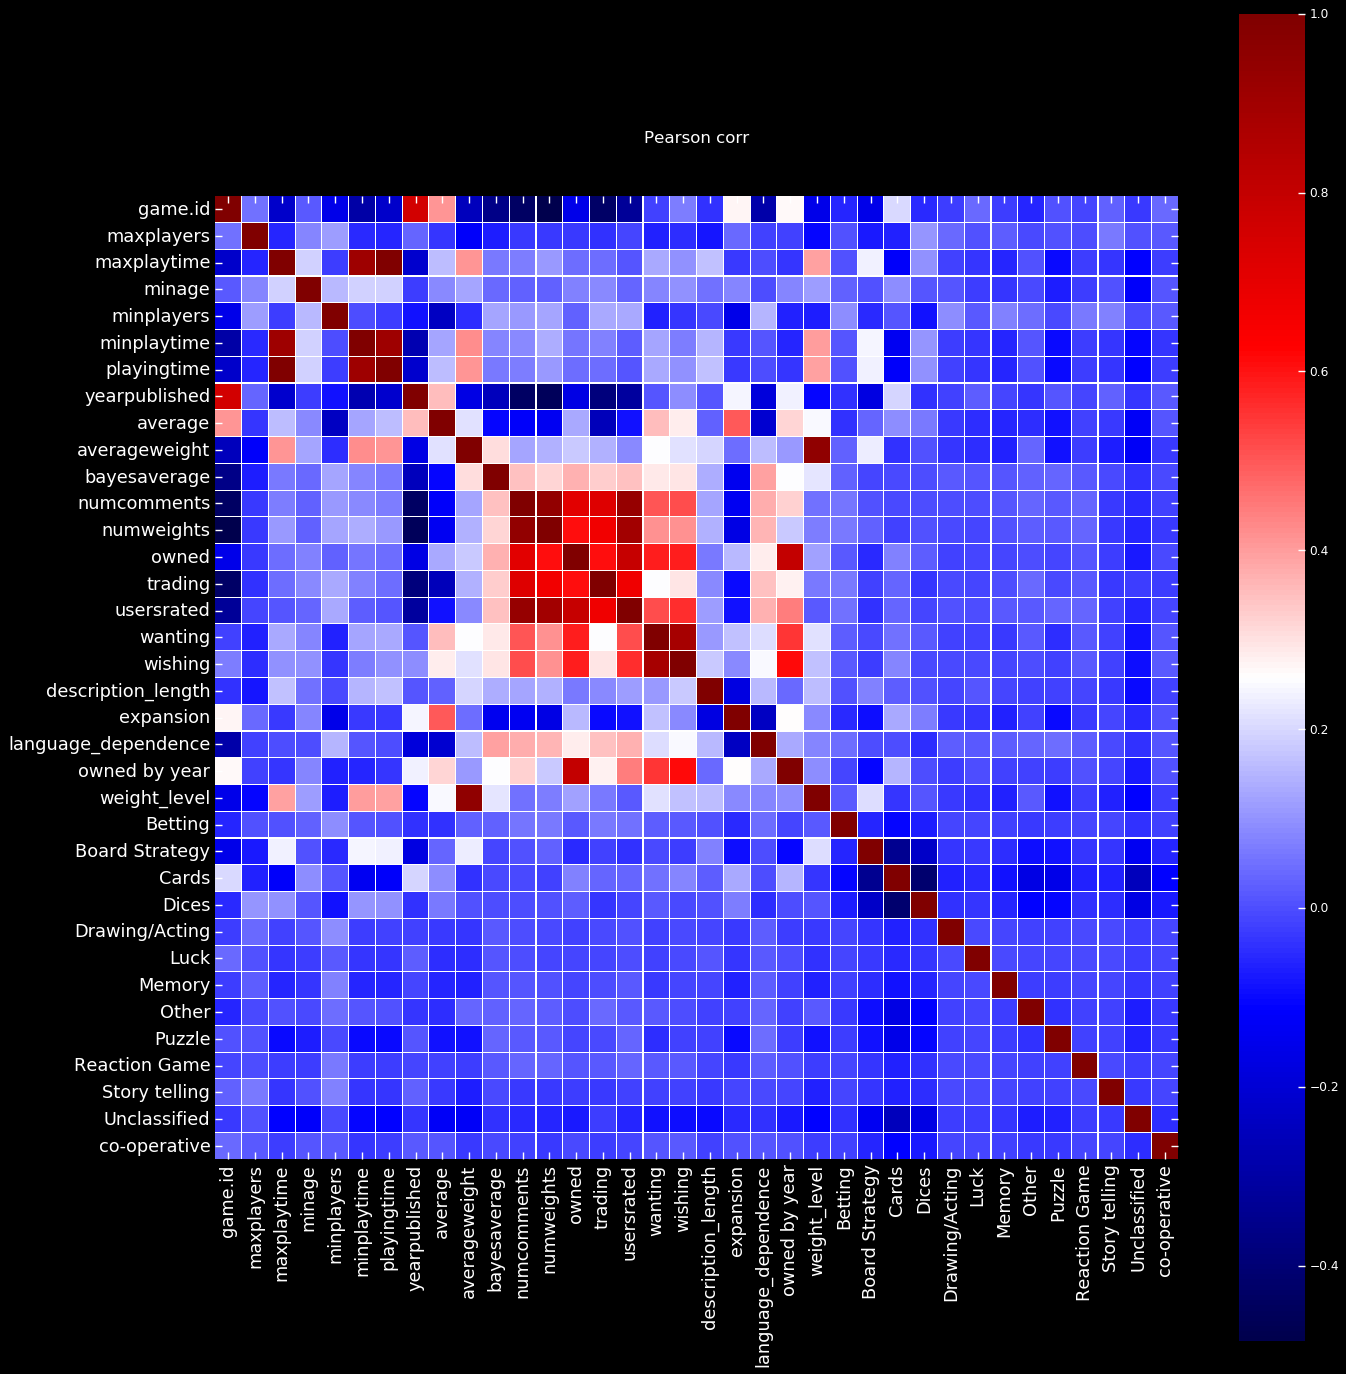

In [266]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (18,18)
colormap=plt.cm.seismic
plt.title("Pearson corr", y=1.05, size=15)
sns.set_context("notebook", font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white")
plt.tight_layout()
# plt.savefig("corr.png", dpi=400)
plt.show()

Let's investigate what features we can use to predict **best selling** board-games.

In [267]:
corr_matrix = df.corr()
corr_vals = (corr_matrix["rating"]).sort_values(ascending=False)

KeyError: 'rating'

In [ ]:
corr_vals[1:]

Lets select the features that seem to correlate better with best selling games

In [ ]:
df_model = df[["yearpublished", "language_dependence", "weight_level", "description_length", "minage", "expansion", "minplaytime",  "minplayers",
              "Cards", "Board Strategy", "owned by year"]]

In [1004]:
df_model.columns = ["year_published", 'language_dependence', 'weight_level', 'description_length', 'min_age',
       'expansion', 'min_playtime', 'min_players',"cards", 'board_strategy','games_sold']

## 3. Data Split and Data Preprocessing

In [454]:
X = df_model.drop("games_sold", axis=1)
y = df_model["games_sold"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

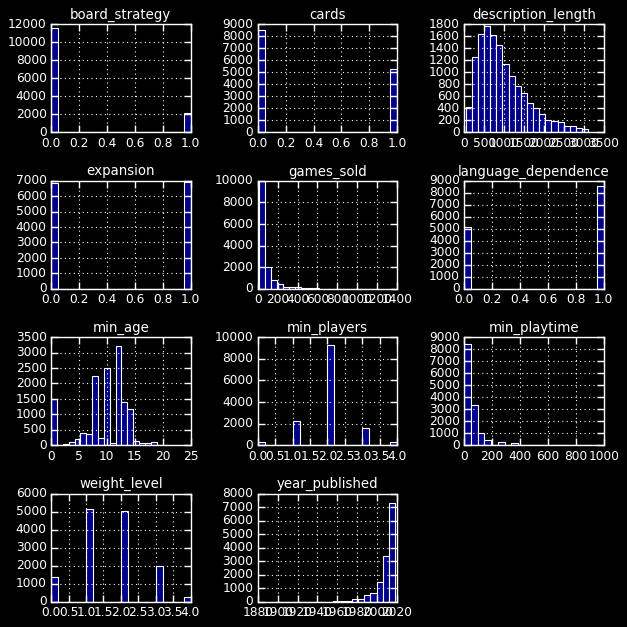

In [455]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,8)
df_model.hist(bins=20, color="darkblue")
plt.xticks(fontsize=8, color = "k")
plt.tight_layout()
# plt.savefig("hist_features.png", dpi=400)
plt.show()

We observe that the distribution of values is generally skewed and variables possess different scales, hence modeling would benefit from a scandard scalarization.

In [456]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

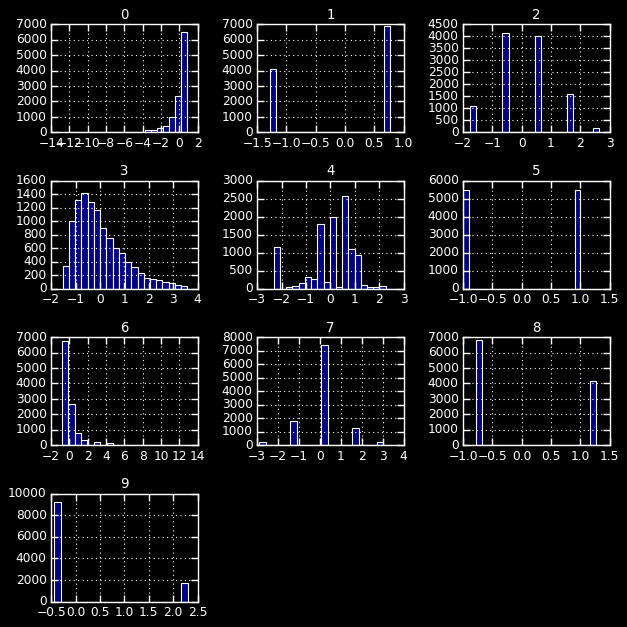

In [457]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,8)
pd.DataFrame(X_train).hist(bins=20, color="darkblue")
plt.xticks(fontsize=8, color = "k")
plt.tight_layout()
# plt.savefig("hist_features.png", dpi=400)
plt.show()

## 4. Exploring Model Performance

In [459]:
# Exploring model performance of different regression models 
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))
models.append(('ABR', AdaBoostRegressor()))
xgbr_params = {'objective':'reg:squarederror'}
models.append(('XGB', xgb.XGBRegressor(**xgbr_params)))

results_model = []
names_model = []
for name, model in models:
    start  = dt.datetime.now() 
    KF = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_root_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    end  = dt.datetime.now() 
    duration = (end-start).seconds
    msg = "%s: %f (%f) Running time: %s sec" % (name, cv_results.mean(), cv_results.std(), duration)
    print(msg)

LR: -84.730137 (5.581290) Running time: 0 sec
Lasso: -84.779284 (5.695564) Running time: 0 sec
EN: -85.728598 (6.010032) Running time: 0 sec
CART: -105.582579 (5.166629) Running time: 0 sec
KNN: -83.101973 (5.103127) Running time: 0 sec
SVR: -88.943436 (6.362172) Running time: 30 sec
RFR: -77.871558 (5.219211) Running time: 22 sec
GBR: -78.840976 (4.760786) Running time: 6 sec
ETR: -81.321637 (5.769559) Running time: 16 sec
ABR: -100.134074 (6.489376) Running time: 1 sec
XGB: -78.799638 (4.775838) Running time: 2 sec


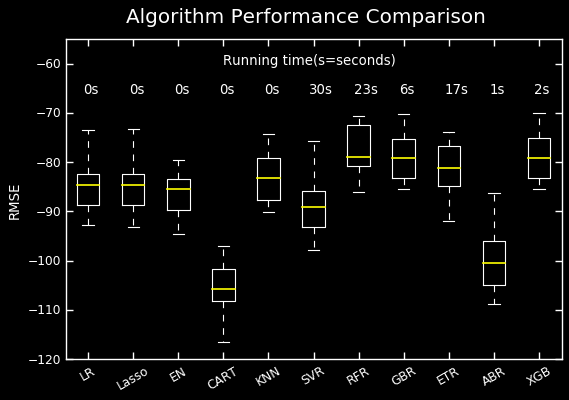

In [460]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)

plt.boxplot(results_model, boxprops=boxprops,medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, showfliers=True, flierprops=flierprops)
plt.ylabel("RMSE")
  
boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

x_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y_values = [85,85,86,105,83,90,77,79,79,100,79]
time_values = ["0s","0s","0s","0s","0s","30s","23s","6s","17s","1s","2s"]

plt.text(s="Running time(s=seconds)", x = 4, y = -60, color="w") 
plt.ylim(-120, -55)
for i in range(len(y_values)):
    plt.text(s=time_values[i], x = x_values[i]-0.1, y = -66, color="w")    
# #plt.savefig("Algo_comp.png", dpi=400, bbox_inches="tight")

ax = fig.add_subplot(111)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("RMSE")


plt.show()

Considering th running time, as well as performance, it seems that **XGB** is performing best. Lets tune this model next.

## 5. Fine Tunning and model evaluation

Fine tuning using **GridSearchCV**

In [461]:
n_estimators = [80, 100, 120]
max_depth = [8] # 5,10
min_child_weight = [1] #, 3, 5, 8]
gamma=[0.9, 1, 1.1]

param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, n_estimators=n_estimators)


model = xgb.XGBRegressor(**xgbr_params)
KF = KFold(n_splits=5, random_state=42) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: -77.495268 using {'gamma': 1.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 80}

Best: -77.384707 using {'gamma': 1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 80}
-77.498302 (3.223607) with: {'gamma': 0.9, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 80}
-77.867125 (3.204765) with: {'gamma': 0.9, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}
-78.023967 (3.236658) with: {'gamma': 0.9, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 120}
-77.384707 (3.358185) with: {'gamma': 1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 80}
-77.657153 (3.302922) with: {'gamma': 1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}
-77.813840 (3.267953) with: {'gamma': 1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 120}
-77.502447 (3.387623) with: {'gamma': 1.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 80}
-77.802172 (3.384053) with: {'gamma': 1.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}
-77.975729 (3.371976) with: {'gamma': 1.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estim

In [462]:
xgbr_params = {'objective':'reg:squarederror'}
XGBoost = xgb.XGBRegressor(max_depth=5, gamma=0.8, min_child_weight=1, n_estimators=80, **xgbr_params) # adjusting parameters to avoid overfitting
XGBoost.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.8,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=80,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [463]:
XGBoost.score(X_train,y_train)

0.4046893956821609

In [464]:
XGBoost.score(X_test,y_test)

0.3093906827623979

**Analyzing Feature importance**: One of the interesting aspects of machine learning is that we can use models to better understand the weight or importance of each feature for predicting the target value.

In [465]:
feat_imp = pd.Series(XGBoost.feature_importances_)
features = pd.Series(X.columns)

In [466]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [467]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

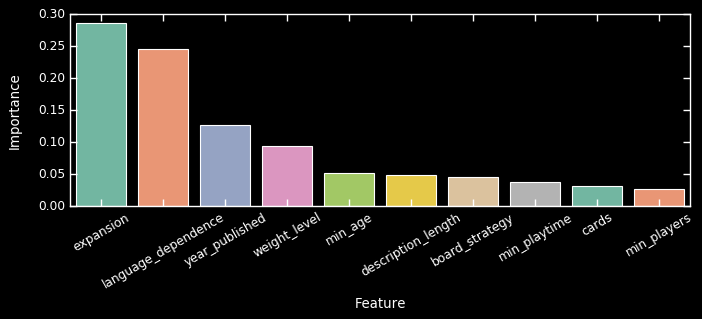

In [468]:
plt.rcParams["figure.figsize"] = (10,3)
imp_pallete = sns.color_palette("Set2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=30)
plt.ylabel("Importance", labelpad=15)
plt.show()

Overall, some of the interesting insights we got from our analyses is that **highly sold games** are: 
 * **Card games** 
 * With a **medium level of difficulty**.
 * **High minimum age**
 * With **no time or player restrains**.
 * **Expansions** (Normal, since they are well-stablished games)

**Future work**:
   * It would be interesting to get the **prices** of each boardgame to analyze whether if card games are sold mostly because they are often cheaper.
   * With the price info we could also create a new feature of **price * owner** to study in what boardgames most money has been spent on.
   * Finally, with price invested in the manufacturing of each game we could finally obtain a list of the **most profitable games**
    